**Target:**

    -- In the last step, we saw that the training accuracy is increasing but the test accuracy is going up and down a little (which means the model is not able to find minima). So, we want to introduce learning rate now

**Results:**

    -- Parameters: 9,907
    -- Best Training Accuracy: 97.89
    -- Best Test Accuracy: 99.36


**Analysis:**

    -- The accuracy has increased a little (from 99.31 to 99.36) after introducing learning rate scheduler.
    -- The training accuracy is same as previous step. 
    -- In the lest few epochs, the test accuracy is not introducing with increase in train accuracy. this means the model starts overfitting

#**Import libraries**

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#**Data Transformations (without normalization)** 

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      transforms.ToTensor()
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor()
                                       ])


# **Dataset and Creating Train/Test Split (without normalization)**

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# **Dataloader Arguments & Test/Train Dataloaders (without normalization)**


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#**Data Transformations (with normalization)**

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])


# **Dataset and Creating Train/Test Split (with normalization)**

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# **Dataloader Arguments & Test/Train Dataloaders (with normalization)**


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


#**plot some images to see which image augmentation to use (with normalization)**
We will plot some images to see which image augmentation technique we can use

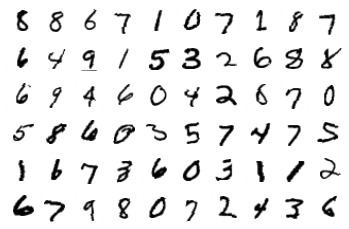

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

**Model**

In [ ]:
dropout_value = 0.05
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    #input block
    self.convblock1 = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 1),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU(),
                                    nn.Dropout(dropout_value)) #R_in = 1, C_in = 28, K = 3, P = 1, S = 1, J_in = 1, J_out = 1, R_out = R_in + (K-1)*J_in =  1+ (3-1)*1 = 3, C_out = 28
    
    #conv block 1
    self.convblock2 = nn.Sequential(nn.Conv2d(in_channels = 16, out_channels = 12, kernel_size = 3, padding = 1),
                                    nn.BatchNorm2d(12),
                                    nn.ReLU(),
                                    nn.Dropout(dropout_value)) #R_in = 3, C_in = 28, K = 3, P = 1, S = 1, J_in = 1, J_out = 1, R_out = R_in + (K-1)*J_in =  3+ (3-1)*1 = 5, , C_out = 28
    
    #conv block 2
    self.convblock3 = nn.Sequential(nn.Conv2d(in_channels = 12, out_channels = 16, kernel_size = 3, padding = 1),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU(),
                                    nn.Dropout(dropout_value)) #R_in = 5, C_in = 28, K = 3, P = 1, S = 1, J_in = 1, J_out = 1, R_out = R_in + (K-1)*J_in =  5+ (3-1)*1 = 7, , C_out = 28
    
    #transition block1
    self.convblock4 = nn.Sequential(nn.Conv2d(in_channels = 16, out_channels = 12, kernel_size = 3, padding = 1),
                                    nn.BatchNorm2d(12),
                                    nn.ReLU(),
                                    nn.Dropout(dropout_value)) #R_in = 7, C_in = 28, K = 3, P = 1, S = 1, J_in = 1, J_out = 1, R_out = R_in + (K-1)*J_in =  7+ (3-1)*1 = 9, , C_out = 28

    self.pool1 = nn.MaxPool2d(2, 2) #R_in = 9, C_in = 28, K = 2, P = 0, S = 2, J_in = 1, J_out = 2, R_out = R_in + (K-1)*J_in =  9+ (2-1)*1 = 9, , C_out = 14

    #conv block 3
    self.convblock5 = nn.Sequential(nn.Conv2d(in_channels = 12, out_channels = 15, kernel_size = 3, padding = 1),
                                    nn.BatchNorm2d(15),
                                    nn.ReLU(),
                                    nn.Dropout(dropout_value)) #R_in = 9, C_in = 14, K = 3, P = 1, S = 1, J_in = 2, J_out = 2, R_out = R_in + (K-1)*J_in =  9+ (3-1)*2 = 13, , C_out = 14
    
    #conv block 4
    self.convblock6 = nn.Sequential(nn.Conv2d(in_channels = 15, out_channels = 12, kernel_size = 3, padding = 1),
                                    nn.BatchNorm2d(12),
                                    nn.ReLU(),
                                    nn.Dropout(dropout_value)) #R_in = 13, C_in = 14, K = 3, P = 1, S = 1, J_in = 2, J_out = 2, R_out = R_in + (K-1)*J_in =  13+ (3-1)*2 = 17, , C_out = 14
    #gap layer 
    self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)) #R_in = 17, C_in = 14, K = 4, P = 1, S = 1, J_in = 2, J_out = 2, R_out = R_in + (K-1)*J_in =  17+ (4-1)*2 = 23, , C_out = 14

    #output block
    self.convblock7 = nn.Sequential(nn.Conv2d(in_channels = 12, out_channels = 10, kernel_size = 3, padding = 0), nn.Dropout(dropout_value)) #R_in = 23, C_in = 14, K = 3, P = 0, S = 1, J_in = 2, J_out = 2, R_out = R_in + (K-1)*J_in =  23+ (3-1)*2 = 27, , C_out = 12

  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.convblock3(x)
    x = self.convblock4(x)
    x = self.pool1(x)
    x = self.convblock5(x)
    x = self.convblock6(x)
    x = self.gap(x)
    x = self.convblock7(x)
    x = x.view(-1, 10)
    return F.log_softmax(x, dim=-1)

**Model parameters**

In [ ]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = Net().to(device)
summary(model, input_size = (1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
           Dropout-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 12, 28, 28]           1,740
       BatchNorm2d-6           [-1, 12, 28, 28]              24
              ReLU-7           [-1, 12, 28, 28]               0
           Dropout-8           [-1, 12, 28, 28]               0
            Conv2d-9           [-1, 16, 28, 28]           1,744
      BatchNorm2d-10           [-1, 16, 28, 28]              32
             ReLU-11           [-1, 16, 28, 28]               0
          Dropout-12           [-1, 16, 28, 28]               0
    

**Training and Testing**

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.1466168761253357 Batch_id=468 Accuracy=88.36: 100%|██████████| 469/469 [00:18<00:00, 25.57it/s]



Test set: Average loss: 0.0775, Accuracy: 9770/10000 (97.70%)

EPOCH: 1


Loss=0.08993557095527649 Batch_id=468 Accuracy=96.20: 100%|██████████| 469/469 [00:18<00:00, 25.42it/s]



Test set: Average loss: 0.0516, Accuracy: 9845/10000 (98.45%)

EPOCH: 2


Loss=0.04991336166858673 Batch_id=468 Accuracy=96.79: 100%|██████████| 469/469 [00:19<00:00, 24.00it/s]



Test set: Average loss: 0.0374, Accuracy: 9873/10000 (98.73%)

EPOCH: 3


Loss=0.061887603253126144 Batch_id=468 Accuracy=97.03: 100%|██████████| 469/469 [00:18<00:00, 25.55it/s]



Test set: Average loss: 0.0670, Accuracy: 9775/10000 (97.75%)

EPOCH: 4


Loss=0.07905120402574539 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:18<00:00, 25.63it/s]



Test set: Average loss: 0.0314, Accuracy: 9893/10000 (98.93%)

EPOCH: 5


Loss=0.04209110513329506 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:18<00:00, 25.21it/s]



Test set: Average loss: 0.0333, Accuracy: 9891/10000 (98.91%)

EPOCH: 6


Loss=0.018541911616921425 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:18<00:00, 25.14it/s]



Test set: Average loss: 0.0220, Accuracy: 9931/10000 (99.31%)

EPOCH: 7


Loss=0.019929351285099983 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:19<00:00, 24.11it/s]



Test set: Average loss: 0.0228, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.06206450238823891 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:18<00:00, 25.69it/s]



Test set: Average loss: 0.0213, Accuracy: 9940/10000 (99.40%)

EPOCH: 9


Loss=0.0771336480975151 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:18<00:00, 25.18it/s]



Test set: Average loss: 0.0212, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.056498948484659195 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:18<00:00, 25.47it/s]



Test set: Average loss: 0.0204, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.041885796934366226 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:18<00:00, 25.03it/s]



Test set: Average loss: 0.0204, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.05855977535247803 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:20<00:00, 22.46it/s]



Test set: Average loss: 0.0201, Accuracy: 9936/10000 (99.36%)

EPOCH: 13


Loss=0.06352178007364273 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:19<00:00, 24.44it/s]



Test set: Average loss: 0.0202, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.033207859843969345 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:19<00:00, 24.57it/s]



Test set: Average loss: 0.0203, Accuracy: 9936/10000 (99.36%)



In [ ]:
train_losses = [i.item() for i in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

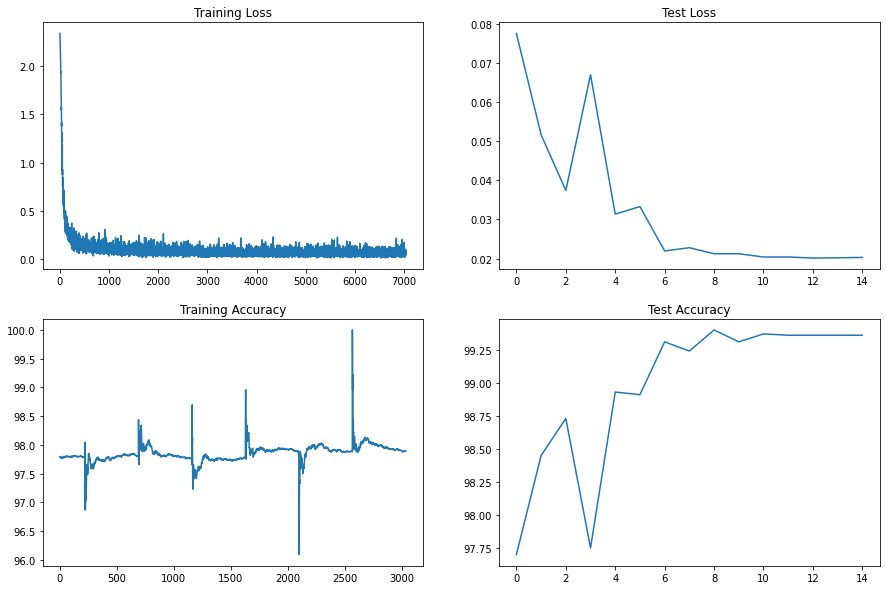

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")